In [1]:
import os
import cv2
import glob
from glob import glob
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from multiprocessing import Pool, cpu_count
from PIL import ImageFilter, ImageStat, Image, ImageDraw
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import display
from collections import defaultdict

Using TensorFlow backend.


In [2]:
def show(X):
    display(Image.fromarray(X))

In [3]:
train_data = np.load('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/resize_data/ALL_TRAIN_SEGPA_10_64.npy')
test_data = np.load('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/resize_data/ALL_TEST_SEGPA_10_64.npy')
train = pd.read_csv('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/resize_data/TRAIN.csv')
test = pd.read_csv('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/resize_data/TEST.csv')
test_id = test.image.values

In [4]:
test_stg2 = pd.read_csv('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/TEST_STG2.csv')
test_stg2_data = np.load('/home/Kaggle_Cervical_Cancer_Screening/Rory/Dev-ipynb/ALL_TEST_STG2_SEGPA_80_64.npy')
test_stg2_id = test_stg2.image.values

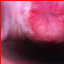

In [9]:
show(train_data[600])

In [6]:
train_data.shape

(8212, 64, 64, 3)

In [7]:
train_data_ud = train_data[:,::-1,:,:]

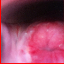

In [10]:
show(train_data_ud[600])

In [11]:
train_data_rl = train_data[:,:,::-1,:]

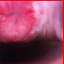

In [12]:
show(train_data_rl[600])

In [13]:
def rotation(image, angle):
    assert image.shape[-1] == 3
    num_rows, num_cols = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), angle, 1)
    img_rotation = cv2.warpAffine(image, rotation_matrix, (num_cols, num_rows))
    return img_rotation

In [14]:
rot_num = 12
rot_imgs = defaultdict(list)
for i in range(train_data.shape[0]):
    for rot in range(int(360/rot_num),360,int(360/rot_num)):
        rot_img = rotation(train_data[i,:,:,:], rot)
        rot_imgs[rot].append(rot_img)

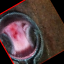

In [15]:
show(rot_imgs[30][600])

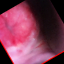

In [16]:
show(rot_imgs[120][600])

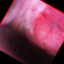

In [17]:
show(rot_imgs[330][600])

In [18]:
train_data = np.concatenate([train_data, train_data_ud, train_data_rl,\
                             np.array(rot_imgs[30]),np.array(rot_imgs[60]),\
                             np.array(rot_imgs[90]),np.array(rot_imgs[120]),\
                             np.array(rot_imgs[150]),np.array(rot_imgs[180]),\
                             np.array(rot_imgs[210]),np.array(rot_imgs[240]),\
                             np.array(rot_imgs[270]),np.array(rot_imgs[300]),\
                             np.array(rot_imgs[330])])

In [19]:
train_data.shape

(114968, 64, 64, 3)

### 增加亮度 

In [20]:
train_data_light = (train_data * 1.2).clip(0,255).astype(np.uint8)

In [21]:
train_data_light.shape

(114968, 64, 64, 3)

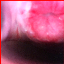

In [22]:
show(train_data_light[600])

### 減少亮度 

In [23]:
train_data_non_light = (train_data * 0.8).clip(0,255).astype(np.uint8)

In [24]:
train_data_non_light.shape

(114968, 64, 64, 3)

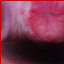

In [25]:
show(train_data_non_light[600])

### 組合

In [26]:
train_X = np.concatenate([train_data,train_data_light,train_data_non_light])

In [27]:
train_X.shape

(344904, 64, 64, 3)

In [28]:
le = LabelEncoder()
train_target = le.fit_transform(train['type'].values)
train_Y = np.concatenate([train_target for i in range(14*3)])

In [29]:
train_X.shape, train_Y.shape

((344904, 64, 64, 3), (344904,))

In [30]:
random_index = np.random.choice(range(train_X.shape[0]), train_X.shape[0], replace = False)

In [31]:
train_X = train_X[random_index]
train_Y = train_Y[random_index]

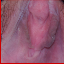

In [32]:
show(train_X[800])

In [48]:
# x_train, x_val_train, y_train, y_val_train =\
# train_test_split(train_X, train_Y, test_size = 0.1, random_state=17)
x_train = train_X
y_train = train_Y

In [49]:
x_train.shape, y_train.shape#, x_val_train.shape, y_val_train.shape

((344904, 64, 64, 3), (344904,))

In [50]:
# 3種 Type
num_classes = 3
y_train = keras.utils.to_categorical(y_train, num_classes)
#y_val_train = keras.utils.to_categorical(y_val_train, num_classes)

In [51]:
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras import optimizers
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [52]:
model = Sequential()
model.add(Reshape((64, 64, 3), input_shape = x_train.shape[1:]))
model.add(Conv2D(8, (3, 3), padding='valid',data_format = "channels_last"))
model.add(Conv2D(8, (3, 3), padding='valid',data_format = "channels_last"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format = "channels_last"))
model.add(Dropout(0.2))

model.add(Conv2D(16, (3, 3), padding='valid',  data_format = "channels_last"))
model.add(Conv2D(16, (3, 3), padding='valid',  data_format = "channels_last"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format = "channels_last"))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), padding='valid',  data_format = "channels_last"))
model.add(Conv2D(32, (3, 3), padding='valid',  data_format = "channels_last"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format = "channels_last"))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='valid',  data_format = "channels_last"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2, 2), data_format = "channels_last"))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(12))
model.add(Activation('tanh'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 62, 62, 8)         224       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 60, 60, 8)         584       
_________________________________________________________________
activation_13 (Activation)   (None, 60, 60, 8)         0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 8)         0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 30, 8)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 16)        1168      
__________

In [53]:
earlystopping = EarlyStopping(monitor='val_loss', patience=2)
adam = Adam(lr=0.001)
model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [54]:
x_train = x_train.astype('float32')
#x_val_train = x_val_train.astype('float32')

x_train /= 255
#x_val_train /= 255

x_test = test_data.astype('float32')
x_test /= 255

In [55]:
x_test_stg2= test_stg2_data.astype('float32')
x_test_stg2 /= 255

In [68]:
model.fit(x_train,
          y_train,
          batch_size = 512,
          epochs = 4,
          validation_split = 0.2,
          callbacks=[earlystopping])

Train on 275923 samples, validate on 68981 samples
Epoch 1/4
275923/275923 [==============================] - 50s - loss: 0.8502 - acc: 0.5819 - val_loss: 0.8157 - val_acc: 0.5998

In [69]:
pred = model.predict_proba(x_test)

448/512 [=========================>....] - ETA: 0s

In [70]:
df = pd.DataFrame(pred, columns=['Type_1','Type_2','Type_3'])
df['image_name'] = test_id
df = df[['image_name','Type_1','Type_2','Type_3']]

In [71]:
sample_submission =\
pd.read_csv('/home/Kaggle_Cervical_Cancer_Screening/submission/sample_submission.csv')

In [72]:
for name in sample_submission['image_name']:
    #print(name)
    #sub[name] = df[df['image_name'] == name][['Type_1','Type_2','Type_3']].values.tolist()[0]
    #print(name)
    Type_1 = df.loc[df['image_name'] == name, 'Type_1']
    Type_2 = df.loc[df['image_name'] == name, 'Type_2']
    Type_3 = df.loc[df['image_name'] == name, 'Type_3']
    
    Type_1_index = Type_1.index[0]
    Type_2_index = Type_2.index[0]
    Type_3_index = Type_3.index[0]
    
    sample_submission.loc[sample_submission['image_name'] == name, 'Type_1'] = Type_1[Type_1_index]
    
    sample_submission.loc[sample_submission['image_name'] == name, 'Type_2'] = Type_2[Type_2_index]
    
    sample_submission.loc[sample_submission['image_name'] == name, 'Type_3'] = Type_3[Type_3_index]

In [73]:
sample_submission.head(10)

,image_name,Type_1,Type_2,Type_3
0,0.jpg,0.103877,0.678252,0.217871
1,1.jpg,0.072694,0.455150,0.472157
2,2.jpg,0.759721,0.200366,0.039913
3,3.jpg,0.068495,0.564195,0.367310
4,4.jpg,0.086849,0.437533,0.475617
5,5.jpg,0.104526,0.874739,0.020735
6,6.jpg,0.477472,0.496181,0.026347
7,7.jpg,0.148423,0.508655,0.342922
8,8.jpg,0.115287,0.460276,0.424437
9,9.jpg,0.211622,0.593442,0.194936


In [74]:
True_outcome = pd.read_csv('/home/dataset/solution_stg1_release.csv')

In [75]:
True_outcome.head(10)

,image_name,Type_1,Type_2,Type_3
0,0.jpg,0,1,0
1,1.jpg,0,1,0
2,2.jpg,1,0,0
3,3.jpg,0,0,1
4,4.jpg,0,0,1
5,5.jpg,0,1,0
6,6.jpg,0,1,0
7,7.jpg,0,1,0
8,8.jpg,0,1,0
9,9.jpg,0,1,0


In [76]:
Pred = sample_submission[["Type_1","Type_2","Type_3"]].values# * 0 + 0.5

In [77]:
Ober = True_outcome[["Type_1","Type_2","Type_3"]].values

In [78]:
func = lambda y, p: y * np.log(max(min(p, 1-10e-15),10e-15))
log_loss = 0.0
for i in range(0, sample_submission.shape[0], 1):

    log_loss += np.sum(np.array(list(map(func, Ober[i], Pred[i]))))
    #print(log_loss)
log_loss /= (-1.) * sample_submission.shape[0]

In [79]:
log_loss

0.81020379483379656

In [80]:
pred_stg2 = model.predict_proba(x_test_stg2)
df_stg2 = pd.DataFrame(pred_stg2, columns=['Type_1','Type_2','Type_3'])
df_stg2['image_name'] = test_stg2_id
df_stg2 = df_stg2[['image_name','Type_1','Type_2','Type_3']]

3392/3506 [============================>.] - ETA: 0s

In [81]:
df_stg2.head()

,image_name,Type_1,Type_2,Type_3
0,12708.jpg,0.199504,0.435455,0.365041
1,13284.jpg,0.164945,0.443459,0.391596
2,11551.jpg,0.080007,0.463528,0.456465
3,11151.jpg,0.145671,0.711184,0.143145
4,11643.jpg,0.264439,0.638956,0.096605


In [82]:
df_stg2.shape

(3506, 4)

In [83]:
df_stg2_submission = pd.concat([sample_submission, df_stg2]).reset_index(drop=True)

In [85]:
df_stg2_submission.to_csv('/home/Kaggle_Cervical_Cancer_Screening/submission/submission_SEGPA_10_014_stg2.csv', index=False)

In [86]:
df_stg2_submission

,image_name,Type_1,Type_2,Type_3
0,0.jpg,0.103877,0.678252,0.217871
1,1.jpg,0.072694,0.455150,0.472157
2,2.jpg,0.759721,0.200366,0.039913
3,3.jpg,0.068495,0.564195,0.367310
4,4.jpg,0.086849,0.437533,0.475617
5,5.jpg,0.104526,0.874739,0.020735
6,6.jpg,0.477472,0.496181,0.026347
7,7.jpg,0.148423,0.508655,0.342922
8,8.jpg,0.115287,0.460276,0.424437
9,9.jpg,0.211622,0.593442,0.194936
